In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

## 데이터셋 

In [2]:
#데이터 읽자
#천단위 콤마 제거 해주자 나중에 또 하기 귀찮으니까!(결정적으로 float형 유지를 위해)
df = pd.read_csv('exchange_rate_fix_20210223.xls.csv', thousands = ',')
print(df.shape)
df.tail()

(1762, 8)


,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,달러지수 (종가),콜금리,KOSPI
1757,2021.02.17,"1,099.70",6764.11,0.87,NaN,90.95,0.47,"3,133.73"
1758,2021.02.18,"1,107.70",6652.76,0.87,NaN,90.59,0.49,"3,086.66"
1759,2021.02.19,"1,105.70",6712.32,0.86,NaN,90.36,0.51,"3,107.62"
1760,2021.02.22,"1,107.10",6635.92,0.86,NaN,90.01,0.50,"3,079.75"
1761,2021.02.23,"1,106.50",6607.24,0.86,NaN,90.17,0.49,"3,070.09"


In [3]:
#열이름 한국어인거 영어로 변경하자
name = ["Date", "ExchangeRate","KRX100", "KORIBOR", "LIBOR", "DollarRate",
       "CallRate","KOSPI"]
df1= df.rename(columns = dict(zip(df.columns,name)))

In [4]:
#천단위 쉼표 제거
df1['ExchangeRate'] = df1['ExchangeRate'].str.replace(',','')
df1['KOSPI'] = df1['KOSPI'].str.replace(',','')
df1.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.70,6764.11,0.87,NaN,90.95,0.47,3133.73
1758,2021.02.18,1107.70,6652.76,0.87,NaN,90.59,0.49,3086.66
1759,2021.02.19,1105.70,6712.32,0.86,NaN,90.36,0.51,3107.62
1760,2021.02.22,1107.10,6635.92,0.86,NaN,90.01,0.50,3079.75
1761,2021.02.23,1106.50,6607.24,0.86,NaN,90.17,0.49,3070.09


In [5]:
#오브젝트형 데이터 실수로 형변환
df1["KOSPI"] = pd.to_numeric(df1.KOSPI, errors='coerce')
df1["ExchangeRate"] = pd.to_numeric(df1.ExchangeRate, errors='coerce')

In [6]:
#결측값 확인
df1.isna().sum()

Date             0
ExchangeRate     1
KRX100           6
KORIBOR          0
LIBOR           92
DollarRate       7
CallRate         0
KOSPI            7
dtype: int64

In [7]:
#결측치를 값에 선형 비례하는식으로 결측값을 보간해봤다
df_intp = df1.interpolate(method = 'values')

df_intp.tail()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
1757,2021.02.17,1099.7,6764.11,0.87,0.0815,90.95,0.47,3133.73
1758,2021.02.18,1107.7,6652.76,0.87,0.0815,90.59,0.49,3086.66
1759,2021.02.19,1105.7,6712.32,0.86,0.0815,90.36,0.51,3107.62
1760,2021.02.22,1107.1,6635.92,0.86,0.0815,90.01,0.50,3079.75
1761,2021.02.23,1106.5,6607.24,0.86,0.0815,90.17,0.49,3070.09


In [8]:
#날짜 데이터타임형식으로 미리 변경해놓자
df_intp['Date'] = pd.to_datetime(df_intp['Date'], errors='coerce')

In [9]:
df_intp.head()

,Date,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
0,2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
1,2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2,2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
3,2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
4,2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


In [10]:
#날짜가 인덱스인 경우도 생성 해놓자
df_date = df_intp.set_index('Date')
df_date.head()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2014-01-02,1055.3,4263.64,2.78,0.0956,80.79,2.51,1967.19
2014-01-03,1050.4,4209.03,2.78,0.0950,80.96,2.50,1946.14
2014-01-06,1054.1,4221.13,2.77,0.0945,80.81,2.48,1953.28
2014-01-07,1062.2,4233.05,2.75,0.0926,80.98,2.50,1959.44
2014-01-08,1067.9,4232.26,2.75,0.0925,81.16,2.49,1958.96


<AxesSubplot:xlabel='Date'>

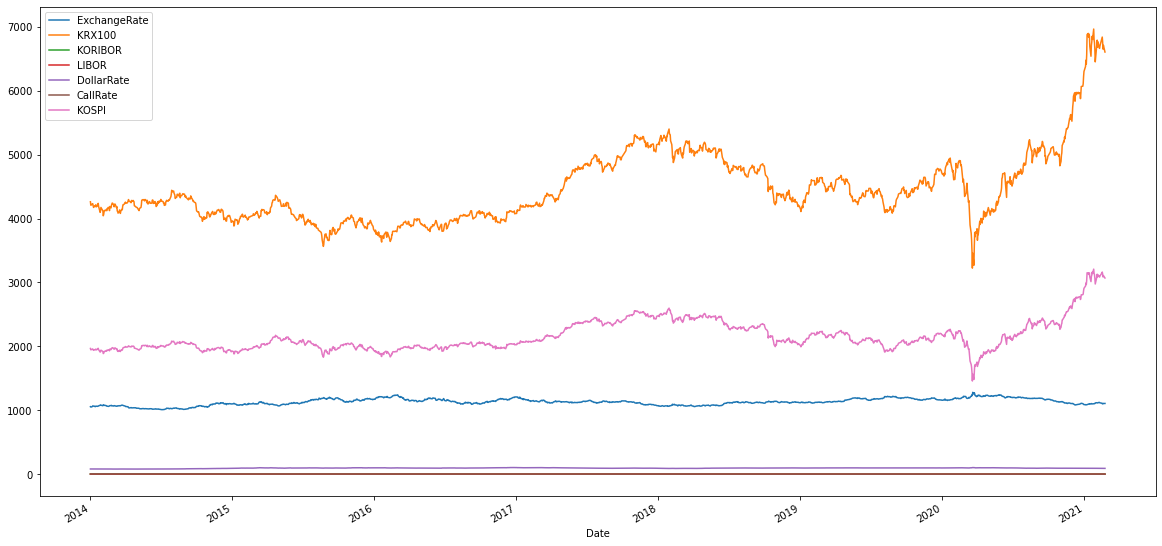

In [11]:
#시각화 해보자
df_intp.plot(x="Date",figsize = (20,10))

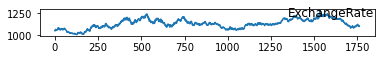

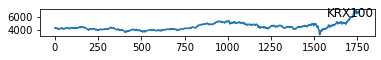

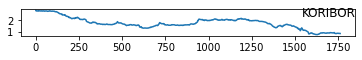

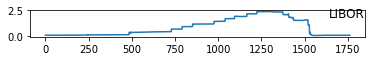

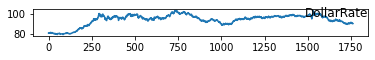

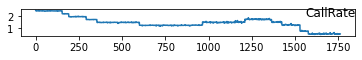

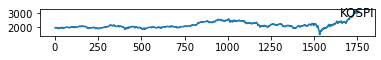

In [12]:
#개별 시각화
groups = [0,1,2,3,4,5,6]
i = 1
#그래프
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(df_date.values[:,group])
    plt.title(df_date.columns[group], y= 0.5, loc= 'right')
    i +=1
    plt.show()

##  차분 
- 데이터가 정상성을 유지 해야하되니까 꼭 해주자
- 그 전에 정상성을 갖고있는지 부터 확인 (adf 검정)

- 귀무가설 : 시계열 변수가 정상성을 갖고 있지 않다(단위근을 갖는다)
- 대립가설 : 시계열 변수가 정상성을 갖고있다

In [13]:
#환율
adfuller_test = adfuller(df_date['ExchangeRate'], autolag = "AIC")
print ("ExchangeRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#krx100
adfuller_test = adfuller(df_date['KRX100'], autolag = "AIC")
print ("KRX100 ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#koribor
adfuller_test = adfuller(df_date['KORIBOR'], autolag = "AIC")
print ("KORIBOR ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#libor
adfuller_test = adfuller(df_date['LIBOR'], autolag = "AIC")
print ("LIBOR ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#Dollarrate
adfuller_test = adfuller(df_date['DollarRate'], autolag = "AIC")
print ("DollarRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#callrate
adfuller_test = adfuller(df_date['CallRate'], autolag = "AIC")
print ("CallRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#kospi
adfuller_test = adfuller(df_date['KOSPI'], autolag = "AIC")
print ("KOSPI ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))


ExchangeRate ADF test statistic : -2.596813831487721
p-value: 0.09365757339119885
KRX100 ADF test statistic : 0.0516464188993991
p-value: 0.9626004362776712
KORIBOR ADF test statistic : -1.2280519809925396
p-value: 0.6614135724495864
LIBOR ADF test statistic : -1.0777430677367463
p-value: 0.72386561802668
DollarRate ADF test statistic : -2.406499234649235
p-value: 0.13991044403923425
CallRate ADF test statistic : -1.1195367311553965
p-value: 0.7072183357711792
KOSPI ADF test statistic : -0.3267097127774202
p-value: 0.9216353251449864


### 정상성을 하나도 띄지 않는다
- 차분을 취하자

In [14]:
df_diff = df_date.diff().dropna()

In [15]:
#다시 테스트 해서 확인해보자
#환율
adfuller_test = adfuller(df_diff['ExchangeRate'], autolag = "AIC")
print ("ExchangeRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#krx100
adfuller_test = adfuller(df_diff['KRX100'], autolag = "AIC")
print ("KRX100 ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#koribor
adfuller_test = adfuller(df_diff['KORIBOR'], autolag = "AIC")
print ("KORIBOR ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#libor
adfuller_test = adfuller(df_diff['LIBOR'], autolag = "AIC")
print ("LIBOR ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#Dollarrate
adfuller_test = adfuller(df_diff['DollarRate'], autolag = "AIC")
print ("DollarRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#callrate
adfuller_test = adfuller(df_diff['CallRate'], autolag = "AIC")
print ("CallRate ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))
#kospi
adfuller_test = adfuller(df_diff['KOSPI'], autolag = "AIC")
print ("KOSPI ADF test statistic : {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))


ExchangeRate ADF test statistic : -27.61967494215865
p-value: 0.0
KRX100 ADF test statistic : -27.130556188141195
p-value: 0.0
KORIBOR ADF test statistic : -17.476000137606594
p-value: 4.515977505592858e-30
LIBOR ADF test statistic : -10.814087062367125
p-value: 1.8764247893364856e-19
DollarRate ADF test statistic : -18.696371604614022
p-value: 2.0380289312383375e-30
CallRate ADF test statistic : -27.024997906129105
p-value: 0.0
KOSPI ADF test statistic : -26.667306624000034
p-value: 0.0


## 모델링
- 데이터를 트레인/테스트 셋으로 나누자

In [16]:
#80퍼 
train = df_diff.iloc[:int(0.8 * len(df_date)), :]   
test = df_diff.iloc[int(0.8 * len(df_date)):, :]

In [17]:
test.tail()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2021-02-17,-3.4,-77.34,0.00,0.0,0.44,-0.03,-29.52
2021-02-18,8.0,-111.35,0.00,0.0,-0.36,0.02,-47.07
2021-02-19,-2.0,59.56,-0.01,0.0,-0.23,0.02,20.96
2021-02-22,1.4,-76.40,0.00,0.0,-0.35,-0.01,-27.87
2021-02-23,-0.6,-28.68,0.00,0.0,0.16,-0.01,-9.66


### var 모델의 최적순서 찾자
- var 모델링 과정에서, 최적 AIC를 모델 선택 기준으로 하자
- 그니까 최상의 aic 점수를 바탕으로 var의 p를 선택하자
- p가 커지면 aic 점수가 감소하고 이후 점수가 높아지기 사직하는 것을 의미

In [18]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

C:\Users\82102\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


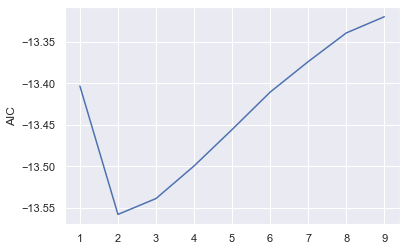

In [19]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.ylabel("AIC")
plt.show()

- 그래프 가장 낮은점수가 2이니까 그 이후는 증가추세를 보이기 때문에 최적 순서는 2

In [20]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 10, Mar, 2021
Time:                     17:44:02
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -13.1659
Nobs:                     1407.00    HQIC:                  -13.4112
Log likelihood:          -4332.33    FPE:                1.29419e-06
AIC:                     -13.5576    Det(Omega_mle):     1.20160e-06
--------------------------------------------------------------------
Results for equation ExchangeRate
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.037653         0.118601            0.317           0.751
L1.ExchangeRate         0.010267         0.024772            0.414           0.679
L1.KRX100               0.035126         0.01

### 예측

In [22]:
lagged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y = lagged_values, steps =352),
                       index = test.index, columns = test.columns)
forecast

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI
Date,,,,,,,
2019-09-24,0.695685,-5.960292,0.000747,0.001905,0.020917,0.000127,-3.280113
2019-09-25,0.864556,-1.722748,0.001064,0.001375,0.037242,0.002276,-0.942406
2019-09-26,0.322440,-0.117962,-0.000126,0.001165,0.011768,-0.000669,-0.075105
2019-09-27,0.227121,0.254555,-0.000396,0.001320,0.015831,-0.000750,0.124019
2019-09-30,0.083125,0.173524,-0.000610,0.001287,0.013010,-0.000507,0.089997
...,...,...,...,...,...,...,...
2021-02-17,0.098912,0.174363,-0.000880,0.001247,0.012666,-0.000688,0.095799
2021-02-18,0.098912,0.174363,-0.000880,0.001247,0.012666,-0.000688,0.095799
2021-02-19,0.098912,0.174363,-0.000880,0.001247,0.012666,-0.000688,0.095799


In [23]:
# 차분 더한 값
forecast['real_ExchangeRate'] = df_date["ExchangeRate"].iloc[-352-1]+ forecast['ExchangeRate'].cumsum()
forecast['real_KRX100'] = df_date["KRX100"].iloc[-352-1]+ forecast['KRX100'].cumsum()
forecast['real_KORIBOR'] = df_date["KORIBOR"].iloc[-352-1]+ forecast['KORIBOR'].cumsum()
forecast['real_LIBOR'] = df_date["LIBOR"].iloc[-352-1]+ forecast['LIBOR'].cumsum()
forecast['real_DollarRate'] = df_date["DollarRate"].iloc[-352-1]+ forecast['DollarRate'].cumsum()
forecast['real_CallRate'] = df_date["CallRate"].iloc[-352-1]+ forecast['CallRate'].cumsum()
forecast['real_KOSPI'] = df_date["KOSPI"].iloc[-352-1]+ forecast['KOSPI'].cumsum()
forecast.head()

,ExchangeRate,KRX100,KORIBOR,LIBOR,DollarRate,CallRate,KOSPI,real_ExchangeRate,real_KRX100,real_KORIBOR,real_LIBOR,real_DollarRate,real_CallRate,real_KOSPI
Date,,,,,,,,,,,,,,
2019-09-24,0.695685,-5.960292,0.000747,0.001905,0.020917,0.000127,-3.280113,1191.795685,4466.459708,1.520747,1.849405,98.620917,1.510127,2088.419887
2019-09-25,0.864556,-1.722748,0.001064,0.001375,0.037242,0.002276,-0.942406,1192.660240,4464.736960,1.521810,1.850780,98.658159,1.512403,2087.477481
2019-09-26,0.322440,-0.117962,-0.000126,0.001165,0.011768,-0.000669,-0.075105,1192.982680,4464.618998,1.521685,1.851945,98.669927,1.511734,2087.402376
2019-09-27,0.227121,0.254555,-0.000396,0.001320,0.015831,-0.000750,0.124019,1193.209801,4464.873553,1.521289,1.853265,98.685758,1.510984,2087.526396
2019-09-30,0.083125,0.173524,-0.000610,0.001287,0.013010,-0.000507,0.089997,1193.292926,4465.047076,1.520678,1.854552,98.698768,1.510477,2087.616393


<AxesSubplot:xlabel='Date'>

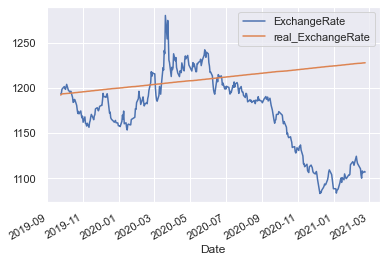

In [24]:
#환율 그래프 보자
test = df_date.iloc[-352:, :1]
test["real_ExchangeRate"] = forecast["real_ExchangeRate"]
test.plot()

In [25]:
test.head()

,ExchangeRate,real_ExchangeRate
Date,,
2019-09-24,1193.1,1191.795685
2019-09-25,1194.0,1192.660240
2019-09-26,1198.3,1192.982680
2019-09-27,1199.1,1193.209801
2019-09-30,1201.3,1193.292926


In [26]:
test.to_excel('predict.xlsx')